# Model NEATM + REFLECT MODEL @python3.8
$D_{eff}=\frac{1329\times10^{-H_v/5}}{\sqrt{p_v}}$
$p_v=\frac{A_B}{q}$
$q_s=\frac{F_{sun}}{d^2}$
$T_{fit}=[\frac{(1-A)F_{sun}}{\eta\epsilon\sigma d}]^{1/4}$
$T=T(\theta,\phi)=T_{fit}\cos^{1/4}\theta\cos^{1/4}\phi,(-\frac{\pi}{2}<\theta<\frac{\pi}{2},-\frac{\pi}{2}<\phi<\frac{\pi}{2})$
$F_\lambda=F(\Delta,d,\alpha|\eta,D)$

$F_\lambda=\frac{\epsilon D^2}{2\Delta ^2}\frac{\pi h c^2}{\lambda ^5}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\frac{1}{exp(\frac{hc}{\lambda kT(\theta,\phi)}-1)}\cos^2 \phi\cos(\alpha-\theta)d\theta$

$F_\lambda=\frac{\epsilon D^2}{4\Delta ^2}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\pi B(T,\lambda)\cos^2 \phi\cos(\alpha-\theta)d\theta$


# MCMC_NEATM

## define const & import

In [1]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 
import pandas as pd
from tqdm import tqdm
import os
#import NEATM
from NEATM import *
#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9             #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
Rsun = 0.00465*au   #Rsun *m
Tsun = 5778         #Tsun  K
Hv = 21.7
G = 0.15
Ndd = 15
lamdai = [3.4,4.6,12,22]

## define MODEL FUNCTION
initial x:flux = delta, it will change "delta"!
list: a,b
a = b
a = b[:]

### Model hhq

In [2]:
def neatm_ohhq(Ndd,eta,D,delta,dd,alpha,lamda,A):   
    summ = 0.
    a = alpha-pi/2
    b = pi/2
    c = -pi/2          
    d = pi/2
    Tfit = np.power((1-A)*Fsun/(eta*epsi*sigma*dd*dd),0.25)
    #print(f"Tss = {Tfit-273}\n")
    dxdy = ((b-a)*(d-c)/(Ndd*Ndd)) 
    for j in range(Ndd):
        for i in range(Ndd):
            phii = (c+(d-c)*j/Ndd)
            thei = (a+(b-a)*i/Ndd)
            T = Tfit*np.power(np.cos(thei),0.25)*np.power(np.cos(phii),0.25)
            integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
            summ = summ + dxdy*integral
    F = (epsi*np.power(D,2)*pi*h*cl*cl)*summ/(2*np.power(delta*au,2)*np.power(lamda,5))
    F = F*(lamda)**2/cl*1e29
    return F
def Model_neatm_Ref_jhx(theta,x,lamda):
    '''
    theta = (eta,D,wf)
    x = (astp,obsp)
    x = (3.4x;4.6x;12x;22x)
    '''
    eta,D,wf = theta
    astp,obsp = x
    lamda1,lamda2,lamda3,lamda4 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial
    nn = len(astp)
    #print(nn)
    qutn = int(nn/4)
    flux = np.zeros(nn)
    #w1,w2 with Ref
    for i in range(qutn):
        fluxi,frLambi,frLommi =0,0,0#get_flux_ref(astp[i],obsp[i],D,lamda1,eta,A)
        flux[i] = fluxi + wf*frLambi + frLommi
    for i in range(qutn,qutn*2):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda2,eta,A)
        flux[i] = fluxi + wf*frLambi + frLommi
    #w3,w4 without Ref
    for i in range(qutn*2,qutn*3):
        flux[i] = get_flux_noref(astp[i],obsp[i],D,lamda3,eta,A)
        #flux[i] ,frLambi,frLommi= get_flux_ref(astp[i],obsp[i],D,lamda3,eta,A)
    for i in range(qutn*3,qutn*4):
        flux[i] = get_flux_noref(astp[i],obsp[i],D,lamda3,eta,A)
        #flux[i] ,frLambi,frLommi= get_flux_ref(astp[i],obsp[i],D,lamda4,eta,A)
    flux234 = flux[qutn:]
    return flux234
    
def Model_neatm_ohhq(theta,x,lamda):
    eta,D = theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda1*1e-6,A)
    for i in range(int(nn/2),nn):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda2*1e-6,A)
    return flux

## read data file

#### 处理原始数据 将坐标垂直叠加，方便直接计算12，22微米的流量

In [3]:
namelist = ['2003MA3','2010CO1','2010DG77','2010EX11','2010FC81','2010FH81','2010GS7','2010JN71','2010KX7','2010PW58','2010XP69','2019DD2']
name = '2010fh81'

#### read data & cal  
$x\equiv \Delta,d,\alpha$

In [4]:
obsec = np.loadtxt(f'newepoch_{name}.txt')
name = namelist[1].lower()
obsec = np.loadtxt(f'newepoch_{name}.txt')
obsdat12 = np.loadtxt(f'w12_{name}.txt')
obsdat34 = np.loadtxt(f'w34_{name}.txt')
#ast-sun
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
#print('ast-sun',d_N)
#ast-earth
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#print('ast-earth',delta_N)
#earth-sun
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
#print('earth-sun',dd_N)
#alpha
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
#print("alpha",alpha_N/pi*180,'\n')
x = (delta_N,d_N,alpha_N)
x1 = np.vstack((obsec[:,0:3],obsec[:,0:3]))
x2 = np.vstack((obsec[:,3:6],obsec[:,3:6]))
x_jhx = (x1,x2)
astpp,obss = x_jhx
y = np.hstack((obsdat12,obsdat34))
y234 = y[len(y)//4:]

In [5]:
Dtest = 346
pv = (1329*pow(10,-Hv/5)/(Dtest*0.001))**2
q = 0.29+0.684*G
At = q*pv
fluxi,frLambi,frLommi = get_flux_ref(x_jhx[0][0],x_jhx[1][0],346,3.4,1.2,At)
print(fluxi)
print(Model_neatm_Ref_jhx((1.2,346,1),x_jhx,lamdai))

0.1208658974913903
[ 1.23028869  3.11599256  3.11601399  3.13825218  3.160671    3.18327168
  3.22904425  3.2406081   3.25219622  3.2638531   3.27553397  3.27555647
  3.2872842   3.29908133  3.31090254  3.3109253   3.32279374  3.33473219
  3.34669479  3.34671801  3.35872801  3.37080882  3.38291385  3.38293734
  3.3950901   3.4195627   3.43188295  3.48162311  3.5067723   3.5321162
  3.55768032  4.17016142 22.76351338 50.04829846 50.04859455 50.35577211
 50.66522106 50.97695491 51.60761593 51.76680054 51.92626157 52.08661073
 52.24723174 52.24754096 52.408748   52.57085018 52.73322441 52.733537
 52.89650081 53.06036661 53.22450446 53.22482294 53.38955125 53.55519072
 53.72110201 53.72142393 53.88792883 54.22304535 54.3916612  55.07178843
 55.41529332 55.76120527 56.10986806 64.3906095  22.76351338 50.04829846
 50.04859455 50.35577211 50.66522106 50.97695491 51.60761593 51.76680054
 51.92626157 52.08661073 52.24723174 52.24754096 52.408748   52.57085018
 52.73322441 52.733537   52.8965008

/home/astrohhq/learngit/reflet234/NEATM.py:187: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/home/astrohhq/learngit/reflet234/NEATM.py:115: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


##### plot $F_v^{ref}-\lambda$

In [6]:
astp,obsp = obsec[:,0:3],obsec[:,3:6]
delta0,d0,alpha0 = x[0][0],x[1][0],x[2][0]
arraylam = np.linspace(0,22,100)
#refledF = NEATM.get_flux_ref(346,delta0,d0,alpha0,arraylam*1e-6,0.9)
Dtest = 346
pv = (1329*pow(10,-Hv/5)/(Dtest*0.001))**2
q = 0.29+0.684*G
At = q*pv
refledF = get_flux_ref(astp[0],obsp[0],Dtest,3.4,1.2,At)
flux = neatm_ohhq(10,1.2,Dtest,delta0,d0,alpha0,3.4e-6,At)
print(Model_neatm_Ref_jhx((1.2,346,0.2),x_jhx,lamdai))


[ 1.22805452  3.11069911  3.1107205   3.1329245   3.15530886  3.1778748
  3.22357703  3.23512312  3.24669343  3.25833241  3.26999533  3.27001779
  3.28172751  3.29350652  3.30530957  3.30533229  3.3171825   3.32910261
  3.34104685  3.34107003  3.35306158  3.36512384  3.37721028  3.37723373
  3.38936782  3.41380285  3.42610418  3.47576796  3.50087854  3.52618353
  3.5517084   4.16324863 22.76351338 50.04829846 50.04859455 50.35577211
 50.66522106 50.97695491 51.60761593 51.76680054 51.92626157 52.08661073
 52.24723174 52.24754096 52.408748   52.57085018 52.73322441 52.733537
 52.89650081 53.06036661 53.22450446 53.22482294 53.38955125 53.55519072
 53.72110201 53.72142393 53.88792883 54.22304535 54.3916612  55.07178843
 55.41529332 55.76120527 56.10986806 64.3906095  22.76351338 50.04829846
 50.04859455 50.35577211 50.66522106 50.97695491 51.60761593 51.76680054
 51.92626157 52.08661073 52.24723174 52.24754096 52.408748   52.57085018
 52.73322441 52.733537   52.89650081 53.06036661 53.22

/tmp/ipykernel_3046332/938527387.py:15: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)


#### cal Flex
$F_v^{ast}(\lambda) = F_v^{th}(\lambda) + F_v^{ref}$


##### cal $F_v^{th}+F_v^{ref}$ in W1\W2

In [7]:
flux1234= Model_neatm_Ref_jhx((1.2,200,0.4),x_jhx,lamdai)
nt = len(flux1234)

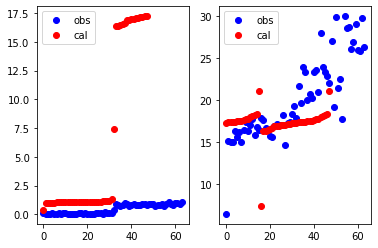

In [8]:
y12 = obsdat12
flux12 = flux1234[0:nt//2]
plt.subplot(1,2,1)
plt.plot(y12,'bo',label = 'obs')
plt.plot(flux12,'ro',label = 'cal')
plt.legend()
y34 = obsdat34
flux34 = flux1234[nt//2:]
plt.subplot(1,2,2)
plt.plot(y34,'bo',label = 'obs')
plt.plot(flux34,'ro',label = 'cal')
plt.legend()

# MCMC

In [9]:
#initial
eta_gs = 1.2
D_gs = 150
eta_gss = [0.5,5]
D_gss = [1,500]
wf_gs = 0.2
wf_gss = [0,0.5]

In [10]:
#MCMC Function
def log_likelihood(theta, x, y, yerr):
    eta,D,wf = theta
    model = Model_neatm_Ref_jhx(theta,x,lamdai)
    #model = eta*x[0]*100 + D
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
def log_prior(theta):
    eta,D,wf = theta
    if eta_gss[0]< eta < eta_gss[1] and D_gss[0] < D < D_gss[1] and wf_gss[0] < wf < wf_gss[1]:
        return 0.0
    return -np.inf
    #return 0
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
     #   print('hi','-inf')
        return -np.inf
    yy=lp + log_likelihood(theta, x, y, yerr)
    #print('hi',yy)
    return yy


In [11]:
#initial para guesses
eta = eta_gs
D = D_gs
wf = wf_gs
theta = [eta, D,wf]

In [12]:
import emcee
#initialize sampler
ndim, nwalkers = len(theta), 10
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x_jhx, y234, y234*0.1))
pos = [theta + 1e-6*np.random.randn(ndim) for i in range(nwalkers)]
#run mcmc
sampler.run_mcmc(pos, 2000, progress=True);

/home/astrohhq/learngit/reflet234/NEATM.py:187: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/home/astrohhq/learngit/reflet234/NEATM.py:115: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
100%|██████████| 2000/2000 [26:59<00:00,  1.24it/s]


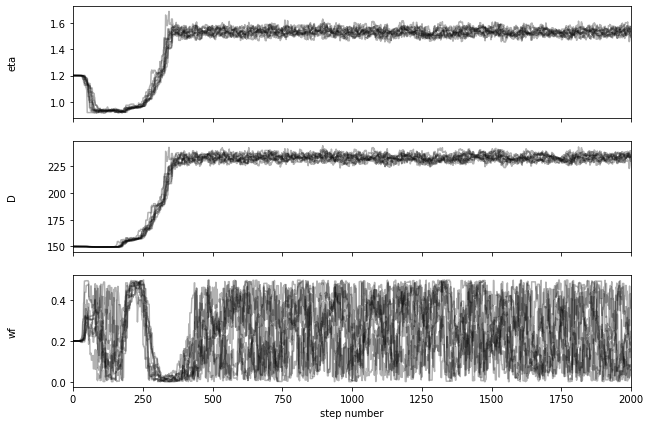

In [13]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["eta", "D", "wf"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");

In [14]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [207.59056158 217.04139854  51.13053611]

In [ ]:
frac = sampler.acceptance_fraction
frac

array([0.549, 0.582, 0.569, 0.603, 0.578, 0.582, 0.56 , 0.554, 0.555,
       0.573])

(1060, 3)


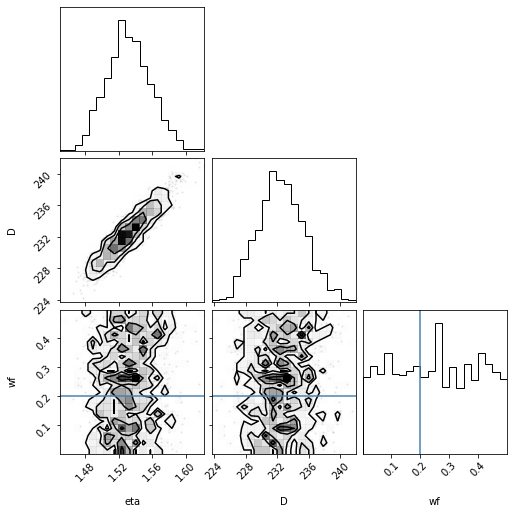

In [15]:
#--------------------------
flat_samples = sampler.get_chain(discard=400, thin=15, flat=True)
print(flat_samples.shape)
import corner
fig = corner.corner(
flat_samples, labels=labels, truths=[eta_gs, D_gs,wf_gs]
);

In [16]:
from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    #print(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))
print(Math(txt))
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
pv = (1329*pow(10,-Hv/5)/(D_fit*0.001))**2
print('eta_gs = ',eta_gs,'D_gs= ',D_gs,'pv=',pv)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>
eta_gs =  1.2 D_gs=  150 pv= 0.06837532750285517


/home/astrohhq/learngit/reflet234/NEATM.py:187: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/home/astrohhq/learngit/reflet234/NEATM.py:115: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


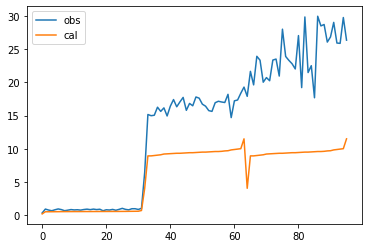

In [17]:
plt.plot(y234,label='obs')
plt.plot(Model_neatm_Ref_jhx(theta,x_jhx,lamdai),label='cal')
plt.legend()

In [18]:
def loss(obs,cal,err):
    l = len(obs)
    return sum(((obs-cal)/err)**2)/l
print('LossFunction = ',loss(y234,Model_neatm_Ref_jhx(theta,x_jhx,lamdai),y234*0.1))

LossFunction =  22.19593342678876


/home/astrohhq/learngit/reflet234/NEATM.py:187: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/home/astrohhq/learngit/reflet234/NEATM.py:115: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


In [19]:
import pandas as pd
rawdata = pd.read_csv(f'time_{name}.txt')
timelist = rawdata['mjd'].tolist()
yerr = y*0.1
len(timelist)

32

In [20]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
eta_low,eta_fit,eta_high = np.percentile(flat_samples[:, 0], [16, 50, 84])
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
wf_low,wf_fit,wf_high = np.percentile(flat_samples[:, 2], [16, 50, 84])

print('eta_fit = ',eta_fit,'D_fit= ',D_fit,'pv = ',(1329*pow(10,-Hv/5)/(D_fit*0.001))**2)
theta = eta_fit,D_fit,wf_fit
flux = Model_neatm_Ref_jhx(theta,x_jhx,lamdai)
qq = 32
ff = np.zeros(32)
print(len(flux))
flux = np.hstack((ff,flux))
flux


eta_fit =  1.5303904299061033 D_fit=  232.31394040409418 pv =  0.06837532750285517
96


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.30431335,  0.78782464,  0.7878302 ,
        0.7935931 ,  0.79940462,  0.80526511,  0.81713994,  0.82014119,
        0.82314924,  0.82617564,  0.82920879,  0.82921463,  0.83226047,
        0.83532486,  0.83839603,  0.83840195,  0.84148594,  0.84458867,
        0.84769823,  0.84770427,  0.85082671,  0.85396814,  0.85711645,
        0.85712256,  0.86028386,  0.86665174,  0.86985843,  0.88281104,
        0.88936394,  0.89597027,  0.9026368 ,  1.06331813,  7.98661523,
       17.64717513, 17.64728017, 17.75625274, 17.86603329, 17.97

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.30431335 0.78782464 0.7878302  0.7935931
 0.79940462 0.80526511 0.81713994 0.82014119 0.82314924 0.82617564
 0.82920879 0.82921463 0.83226047 0.83532486 0.83839603 0.83840195
 0.84148594 0.84458867 0.84769823 0.84770427 0.85082671 0.85396814
 0.85711645 0.85712256 0.86028386 0.86665174 0.86985843 0.88281104
 0.88936394 0.89597027 0.9026368  1.06331813]


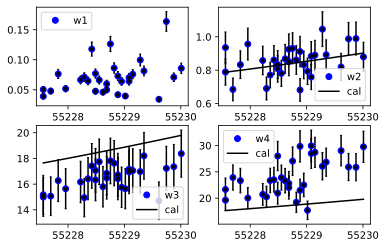

In [21]:


y12 = obsdat12
flux12 = flux[0:qq*2]
print(flux12)
plt.subplot(2,2,1)
plt.plot(timelist[1:qq-1],y12[1:qq-1],'bo',label = 'w1')
plt.errorbar(timelist[1:qq-1],y12[1:qq-1],yerr[1:qq-1],fmt=".k", capsize=1.0)
#plt.plot(timelist[1:qq-1],flux12[1:qq-1],'k',label = 'cal')
plt.legend()
plt.subplot(2,2,2)
plt.plot(timelist[1:qq-1],y12[qq+1:2*qq-1],'bo',label = 'w2')
plt.errorbar(timelist[1:qq-1],y12[qq+1:2*qq-1],yerr[qq+1:2*qq-1],fmt=".k", capsize=1.0)
plt.plot(timelist[1:qq-1],flux12[qq+1:2*qq-1],'k',label = 'cal')
plt.legend()
y34 = obsdat34
flux34 = flux[qq*2:]
plt.subplot(2,2,3)
plt.plot(timelist[1:qq-1],y34[1:qq-1],'bo',label = 'w3')
plt.errorbar(timelist[1:qq-1],y34[1:qq-1],y34[1:qq-1]*0.1,fmt=".k", capsize=1.0)
plt.plot(timelist[1:qq-1],flux34[1:qq-1],'k',label = 'cal')
plt.legend()
plt.subplot(2,2,4)
plt.plot(timelist[1:qq-1],y34[qq+1:2*qq-1],'bo',label = 'w4')
plt.errorbar(timelist[1:qq-1],y34[qq+1:2*qq-1],y34[qq+1:2*qq-1]*0.1,fmt=".k", capsize=1.0)
plt.plot(timelist[1:qq-1],flux34[qq+1:2*qq-1],'k',label = 'cal')
plt.legend()
plt.savefig('w234.png')
